In [1]:
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sweetviz

from sklearn.model_selection import train_test_split
from nflows.distributions import ConditionalDiagonalNormal

from src.probabilistic_flow_boosting.tfboost.tree import EmbeddableCatBoostPriorNormal, EmbeddableOneHotEncoder
from src.probabilistic_flow_boosting.tfboost.tfboost import TreeFlowBoost
from src.probabilistic_flow_boosting.tfboost.flow import ContinuousNormalizingFlow
from src.probabilistic_flow_boosting.pipelines.reporting.nodes import calculate_nll

from src.probabilistic_flow_boosting.pipelines.modeling.utils import setup_random_seed

RANDOM_SEED = 42

setup_random_seed(RANDOM_SEED)

/home/pwielopolski/anaconda3/envs/datascience/lib/python3.7/site-packages/scipy/__init__.py:149: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.4
  UserWarning)
In /home/pwielopolski/anaconda3/envs/datascience/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pwielopolski/anaconda3/envs/datascience/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pwielopolski/anaconda3/envs/datascience/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' 

In [2]:
df = pd.read_csv('data/01_raw/CatData/laptop/laptop_price.csv', index_col=0, engine='python')

In [3]:
df['Weight'] = pd.to_numeric(df['Weight'].str.replace('kg', ''))
df['Ram'] = pd.to_numeric(df['Ram'].str.replace('GB', ''))

In [4]:
# analysis = sweetviz.analyze(df)
# analysis.show_notebook()

In [5]:
x = df.drop(columns = ['Product', 'Price_euros'])
y = np.log10(df[['Price_euros']])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [7]:
x_train.shape, x_test.shape

((1042, 10), (261, 10))

In [8]:
model = catboost.CatBoostRegressor(
    cat_features=['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys'], 
    loss_function="RMSEWithUncertainty",
    num_trees=2000
)

In [9]:
%time model.fit(x_tr, y_tr, eval_set=(x_val, y_val))

0:	learn: 0.0958284	test: 0.0859874	best: 0.0859874 (0)	total: 50.4ms	remaining: 1m 40s
1:	learn: 0.0670829	test: 0.0550898	best: 0.0550898 (1)	total: 54.1ms	remaining: 54s
2:	learn: 0.0453514	test: 0.0323329	best: 0.0323329 (2)	total: 56.7ms	remaining: 37.8s
3:	learn: 0.0215535	test: 0.0092975	best: 0.0092975 (3)	total: 59.5ms	remaining: 29.7s
4:	learn: -0.0027601	test: -0.0139912	best: -0.0139912 (4)	total: 62.4ms	remaining: 24.9s
5:	learn: -0.0209713	test: -0.0354786	best: -0.0354786 (5)	total: 65.2ms	remaining: 21.7s
6:	learn: -0.0376167	test: -0.0509143	best: -0.0509143 (6)	total: 68ms	remaining: 19.4s
7:	learn: -0.0560636	test: -0.0691506	best: -0.0691506 (7)	total: 70.2ms	remaining: 17.5s
8:	learn: -0.0750582	test: -0.0876284	best: -0.0876284 (8)	total: 72.7ms	remaining: 16.1s
9:	learn: -0.0921590	test: -0.1036086	best: -0.1036086 (9)	total: 74.7ms	remaining: 14.9s
10:	learn: -0.1062926	test: -0.1163432	best: -0.1163432 (10)	total: 76.6ms	remaining: 13.8s
11:	learn: -0.1219228	t

119:	learn: -0.8651107	test: -0.7746019	best: -0.7746019 (119)	total: 236ms	remaining: 3.7s
120:	learn: -0.8672015	test: -0.7752743	best: -0.7752743 (120)	total: 238ms	remaining: 3.7s
121:	learn: -0.8708719	test: -0.7759556	best: -0.7759556 (121)	total: 240ms	remaining: 3.7s
122:	learn: -0.8752811	test: -0.7784088	best: -0.7784088 (122)	total: 242ms	remaining: 3.69s
123:	learn: -0.8789265	test: -0.7812222	best: -0.7812222 (123)	total: 244ms	remaining: 3.69s
124:	learn: -0.8824949	test: -0.7834455	best: -0.7834455 (124)	total: 246ms	remaining: 3.69s
125:	learn: -0.8850924	test: -0.7833872	best: -0.7834455 (124)	total: 247ms	remaining: 3.68s
126:	learn: -0.8877139	test: -0.7832459	best: -0.7834455 (124)	total: 250ms	remaining: 3.69s
127:	learn: -0.8909640	test: -0.7845005	best: -0.7845005 (127)	total: 253ms	remaining: 3.69s
128:	learn: -0.8936226	test: -0.7844512	best: -0.7845005 (127)	total: 255ms	remaining: 3.69s
129:	learn: -0.8957312	test: -0.7850213	best: -0.7850213 (129)	total: 256

231:	learn: -1.1162248	test: -0.8031442	best: -0.8140159 (190)	total: 424ms	remaining: 3.23s
232:	learn: -1.1171327	test: -0.8027482	best: -0.8140159 (190)	total: 426ms	remaining: 3.23s
233:	learn: -1.1187941	test: -0.8003819	best: -0.8140159 (190)	total: 428ms	remaining: 3.23s
234:	learn: -1.1209856	test: -0.7998546	best: -0.8140159 (190)	total: 429ms	remaining: 3.23s
235:	learn: -1.1227844	test: -0.7975123	best: -0.8140159 (190)	total: 431ms	remaining: 3.22s
236:	learn: -1.1258297	test: -0.7977375	best: -0.8140159 (190)	total: 433ms	remaining: 3.22s
237:	learn: -1.1269426	test: -0.7965627	best: -0.8140159 (190)	total: 435ms	remaining: 3.22s
238:	learn: -1.1288514	test: -0.7947888	best: -0.8140159 (190)	total: 437ms	remaining: 3.22s
239:	learn: -1.1310132	test: -0.7954749	best: -0.8140159 (190)	total: 439ms	remaining: 3.22s
240:	learn: -1.1346574	test: -0.7955031	best: -0.8140159 (190)	total: 441ms	remaining: 3.22s
241:	learn: -1.1370350	test: -0.7961704	best: -0.8140159 (190)	total: 

340:	learn: -1.2809926	test: -0.7814874	best: -0.8140159 (190)	total: 616ms	remaining: 3s
341:	learn: -1.2826059	test: -0.7812772	best: -0.8140159 (190)	total: 618ms	remaining: 3s
342:	learn: -1.2835349	test: -0.7816229	best: -0.8140159 (190)	total: 620ms	remaining: 2.99s
343:	learn: -1.2848989	test: -0.7808136	best: -0.8140159 (190)	total: 622ms	remaining: 2.99s
344:	learn: -1.2858208	test: -0.7803613	best: -0.8140159 (190)	total: 624ms	remaining: 2.99s
345:	learn: -1.2873156	test: -0.7770048	best: -0.8140159 (190)	total: 626ms	remaining: 2.99s
346:	learn: -1.2890624	test: -0.7779022	best: -0.8140159 (190)	total: 628ms	remaining: 2.99s
347:	learn: -1.2909177	test: -0.7771550	best: -0.8140159 (190)	total: 630ms	remaining: 2.99s
348:	learn: -1.2922971	test: -0.7755264	best: -0.8140159 (190)	total: 632ms	remaining: 2.99s
349:	learn: -1.2936960	test: -0.7744661	best: -0.8140159 (190)	total: 633ms	remaining: 2.98s
350:	learn: -1.2945750	test: -0.7727742	best: -0.8140159 (190)	total: 635ms	

448:	learn: -1.3932302	test: -0.6615600	best: -0.8140159 (190)	total: 808ms	remaining: 2.79s
449:	learn: -1.3943328	test: -0.6599322	best: -0.8140159 (190)	total: 810ms	remaining: 2.79s
450:	learn: -1.3952640	test: -0.6586554	best: -0.8140159 (190)	total: 812ms	remaining: 2.79s
451:	learn: -1.3961907	test: -0.6571666	best: -0.8140159 (190)	total: 814ms	remaining: 2.79s
452:	learn: -1.3972481	test: -0.6552964	best: -0.8140159 (190)	total: 816ms	remaining: 2.79s
453:	learn: -1.3982310	test: -0.6553620	best: -0.8140159 (190)	total: 817ms	remaining: 2.78s
454:	learn: -1.3994161	test: -0.6553626	best: -0.8140159 (190)	total: 819ms	remaining: 2.78s
455:	learn: -1.4011307	test: -0.6509969	best: -0.8140159 (190)	total: 821ms	remaining: 2.78s
456:	learn: -1.4018843	test: -0.6503592	best: -0.8140159 (190)	total: 823ms	remaining: 2.78s
457:	learn: -1.4027755	test: -0.6493260	best: -0.8140159 (190)	total: 825ms	remaining: 2.78s
458:	learn: -1.4038459	test: -0.6462812	best: -0.8140159 (190)	total: 

557:	learn: -1.4994375	test: -0.4441868	best: -0.8140159 (190)	total: 999ms	remaining: 2.58s
558:	learn: -1.5005441	test: -0.4388583	best: -0.8140159 (190)	total: 1s	remaining: 2.58s
559:	learn: -1.5014332	test: -0.4394486	best: -0.8140159 (190)	total: 1s	remaining: 2.58s
560:	learn: -1.5020795	test: -0.4370357	best: -0.8140159 (190)	total: 1s	remaining: 2.58s
561:	learn: -1.5028492	test: -0.4346566	best: -0.8140159 (190)	total: 1.01s	remaining: 2.58s
562:	learn: -1.5042199	test: -0.4329236	best: -0.8140159 (190)	total: 1.01s	remaining: 2.57s
563:	learn: -1.5048279	test: -0.4304225	best: -0.8140159 (190)	total: 1.01s	remaining: 2.57s
564:	learn: -1.5053596	test: -0.4258819	best: -0.8140159 (190)	total: 1.01s	remaining: 2.57s
565:	learn: -1.5061512	test: -0.4272104	best: -0.8140159 (190)	total: 1.01s	remaining: 2.57s
566:	learn: -1.5071739	test: -0.4244804	best: -0.8140159 (190)	total: 1.02s	remaining: 2.57s
567:	learn: -1.5081803	test: -0.4228620	best: -0.8140159 (190)	total: 1.02s	rem

668:	learn: -1.5912585	test: -0.1764849	best: -0.8140159 (190)	total: 1.19s	remaining: 2.37s
669:	learn: -1.5917246	test: -0.1743380	best: -0.8140159 (190)	total: 1.19s	remaining: 2.37s
670:	learn: -1.5924247	test: -0.1753776	best: -0.8140159 (190)	total: 1.19s	remaining: 2.36s
671:	learn: -1.5931208	test: -0.1770711	best: -0.8140159 (190)	total: 1.2s	remaining: 2.36s
672:	learn: -1.5936807	test: -0.1739317	best: -0.8140159 (190)	total: 1.2s	remaining: 2.36s
673:	learn: -1.5944281	test: -0.1748240	best: -0.8140159 (190)	total: 1.2s	remaining: 2.36s
674:	learn: -1.5952356	test: -0.1727533	best: -0.8140159 (190)	total: 1.2s	remaining: 2.36s
675:	learn: -1.5958271	test: -0.1671770	best: -0.8140159 (190)	total: 1.2s	remaining: 2.36s
676:	learn: -1.5964264	test: -0.1647065	best: -0.8140159 (190)	total: 1.21s	remaining: 2.35s
677:	learn: -1.5969084	test: -0.1614856	best: -0.8140159 (190)	total: 1.21s	remaining: 2.35s
678:	learn: -1.5976308	test: -0.1574945	best: -0.8140159 (190)	total: 1.21s

772:	learn: -1.6612231	test: 0.1224635	best: -0.8140159 (190)	total: 1.38s	remaining: 2.19s
773:	learn: -1.6621450	test: 0.1284032	best: -0.8140159 (190)	total: 1.38s	remaining: 2.19s
774:	learn: -1.6625189	test: 0.1304070	best: -0.8140159 (190)	total: 1.38s	remaining: 2.19s
775:	learn: -1.6630162	test: 0.1350102	best: -0.8140159 (190)	total: 1.39s	remaining: 2.19s
776:	learn: -1.6634026	test: 0.1386022	best: -0.8140159 (190)	total: 1.39s	remaining: 2.19s
777:	learn: -1.6642158	test: 0.1412945	best: -0.8140159 (190)	total: 1.39s	remaining: 2.18s
778:	learn: -1.6646822	test: 0.1433672	best: -0.8140159 (190)	total: 1.39s	remaining: 2.18s
779:	learn: -1.6651125	test: 0.1459158	best: -0.8140159 (190)	total: 1.39s	remaining: 2.18s
780:	learn: -1.6657057	test: 0.1506711	best: -0.8140159 (190)	total: 1.4s	remaining: 2.18s
781:	learn: -1.6664312	test: 0.1546789	best: -0.8140159 (190)	total: 1.4s	remaining: 2.18s
782:	learn: -1.6673095	test: 0.1554347	best: -0.8140159 (190)	total: 1.4s	remainin

882:	learn: -1.7245058	test: 0.4811769	best: -0.8140159 (190)	total: 1.57s	remaining: 1.99s
883:	learn: -1.7249548	test: 0.4869750	best: -0.8140159 (190)	total: 1.57s	remaining: 1.99s
884:	learn: -1.7253913	test: 0.4877766	best: -0.8140159 (190)	total: 1.58s	remaining: 1.99s
885:	learn: -1.7259840	test: 0.4902024	best: -0.8140159 (190)	total: 1.58s	remaining: 1.99s
886:	learn: -1.7265509	test: 0.4976133	best: -0.8140159 (190)	total: 1.58s	remaining: 1.98s
887:	learn: -1.7272247	test: 0.4947870	best: -0.8140159 (190)	total: 1.58s	remaining: 1.98s
888:	learn: -1.7273818	test: 0.5007243	best: -0.8140159 (190)	total: 1.58s	remaining: 1.98s
889:	learn: -1.7282864	test: 0.5068557	best: -0.8140159 (190)	total: 1.59s	remaining: 1.98s
890:	learn: -1.7288220	test: 0.5106700	best: -0.8140159 (190)	total: 1.59s	remaining: 1.98s
891:	learn: -1.7292871	test: 0.5106687	best: -0.8140159 (190)	total: 1.59s	remaining: 1.98s
892:	learn: -1.7296311	test: 0.5099478	best: -0.8140159 (190)	total: 1.59s	remai

980:	learn: -1.7757506	test: 0.8562493	best: -0.8140159 (190)	total: 1.77s	remaining: 1.83s
981:	learn: -1.7758398	test: 0.8580623	best: -0.8140159 (190)	total: 1.77s	remaining: 1.83s
982:	learn: -1.7762886	test: 0.8597042	best: -0.8140159 (190)	total: 1.77s	remaining: 1.83s
983:	learn: -1.7767447	test: 0.8584483	best: -0.8140159 (190)	total: 1.77s	remaining: 1.83s
984:	learn: -1.7772358	test: 0.8590863	best: -0.8140159 (190)	total: 1.77s	remaining: 1.83s
985:	learn: -1.7778873	test: 0.8565334	best: -0.8140159 (190)	total: 1.78s	remaining: 1.83s
986:	learn: -1.7782920	test: 0.8610504	best: -0.8140159 (190)	total: 1.78s	remaining: 1.83s
987:	learn: -1.7786652	test: 0.8615615	best: -0.8140159 (190)	total: 1.78s	remaining: 1.83s
988:	learn: -1.7787074	test: 0.8666560	best: -0.8140159 (190)	total: 1.78s	remaining: 1.82s
989:	learn: -1.7793948	test: 0.8714133	best: -0.8140159 (190)	total: 1.79s	remaining: 1.82s
990:	learn: -1.7795934	test: 0.8677449	best: -0.8140159 (190)	total: 1.79s	remai

1073:	learn: -1.8275309	test: 1.1669337	best: -0.8140159 (190)	total: 1.96s	remaining: 1.69s
1074:	learn: -1.8282830	test: 1.1704376	best: -0.8140159 (190)	total: 1.96s	remaining: 1.69s
1075:	learn: -1.8290317	test: 1.1745960	best: -0.8140159 (190)	total: 1.96s	remaining: 1.68s
1076:	learn: -1.8295459	test: 1.1705048	best: -0.8140159 (190)	total: 1.96s	remaining: 1.68s
1077:	learn: -1.8305207	test: 1.1758552	best: -0.8140159 (190)	total: 1.96s	remaining: 1.68s
1078:	learn: -1.8309105	test: 1.1807220	best: -0.8140159 (190)	total: 1.97s	remaining: 1.68s
1079:	learn: -1.8320794	test: 1.1872234	best: -0.8140159 (190)	total: 1.97s	remaining: 1.68s
1080:	learn: -1.8324813	test: 1.1914186	best: -0.8140159 (190)	total: 1.97s	remaining: 1.67s
1081:	learn: -1.8328927	test: 1.1944727	best: -0.8140159 (190)	total: 1.97s	remaining: 1.67s
1082:	learn: -1.8341564	test: 1.1909588	best: -0.8140159 (190)	total: 1.97s	remaining: 1.67s
1083:	learn: -1.8343868	test: 1.1915099	best: -0.8140159 (190)	total: 

1183:	learn: -1.8895893	test: 1.6758066	best: -0.8140159 (190)	total: 2.15s	remaining: 1.48s
1184:	learn: -1.8899863	test: 1.6863474	best: -0.8140159 (190)	total: 2.15s	remaining: 1.48s
1185:	learn: -1.8905971	test: 1.6803127	best: -0.8140159 (190)	total: 2.15s	remaining: 1.48s
1186:	learn: -1.8916410	test: 1.6829739	best: -0.8140159 (190)	total: 2.16s	remaining: 1.48s
1187:	learn: -1.8917314	test: 1.6900868	best: -0.8140159 (190)	total: 2.16s	remaining: 1.48s
1188:	learn: -1.8920673	test: 1.6931685	best: -0.8140159 (190)	total: 2.16s	remaining: 1.47s
1189:	learn: -1.8930545	test: 1.6936721	best: -0.8140159 (190)	total: 2.17s	remaining: 1.47s
1190:	learn: -1.8936063	test: 1.7002056	best: -0.8140159 (190)	total: 2.17s	remaining: 1.47s
1191:	learn: -1.8937698	test: 1.7043288	best: -0.8140159 (190)	total: 2.17s	remaining: 1.47s
1192:	learn: -1.8944207	test: 1.7084028	best: -0.8140159 (190)	total: 2.17s	remaining: 1.47s
1193:	learn: -1.8945802	test: 1.7134632	best: -0.8140159 (190)	total: 

1276:	learn: -1.9321444	test: 2.0501742	best: -0.8140159 (190)	total: 2.34s	remaining: 1.32s
1277:	learn: -1.9323843	test: 2.0563250	best: -0.8140159 (190)	total: 2.34s	remaining: 1.32s
1278:	learn: -1.9332084	test: 2.0540449	best: -0.8140159 (190)	total: 2.34s	remaining: 1.32s
1279:	learn: -1.9336599	test: 2.0603859	best: -0.8140159 (190)	total: 2.35s	remaining: 1.32s
1280:	learn: -1.9343302	test: 2.0676946	best: -0.8140159 (190)	total: 2.35s	remaining: 1.32s
1281:	learn: -1.9347114	test: 2.0732159	best: -0.8140159 (190)	total: 2.35s	remaining: 1.31s
1282:	learn: -1.9352686	test: 2.0733601	best: -0.8140159 (190)	total: 2.35s	remaining: 1.31s
1283:	learn: -1.9362179	test: 2.0774169	best: -0.8140159 (190)	total: 2.35s	remaining: 1.31s
1284:	learn: -1.9370067	test: 2.0830728	best: -0.8140159 (190)	total: 2.35s	remaining: 1.31s
1285:	learn: -1.9371418	test: 2.0866368	best: -0.8140159 (190)	total: 2.36s	remaining: 1.31s
1286:	learn: -1.9374672	test: 2.0943339	best: -0.8140159 (190)	total: 

1380:	learn: -1.9812006	test: 2.5080555	best: -0.8140159 (190)	total: 2.53s	remaining: 1.13s
1381:	learn: -1.9817289	test: 2.4981160	best: -0.8140159 (190)	total: 2.53s	remaining: 1.13s
1382:	learn: -1.9820935	test: 2.5060225	best: -0.8140159 (190)	total: 2.53s	remaining: 1.13s
1383:	learn: -1.9826111	test: 2.5143813	best: -0.8140159 (190)	total: 2.54s	remaining: 1.13s
1384:	learn: -1.9834427	test: 2.5284851	best: -0.8140159 (190)	total: 2.54s	remaining: 1.13s
1385:	learn: -1.9835605	test: 2.5384799	best: -0.8140159 (190)	total: 2.54s	remaining: 1.13s
1386:	learn: -1.9845431	test: 2.5391906	best: -0.8140159 (190)	total: 2.54s	remaining: 1.12s
1387:	learn: -1.9852359	test: 2.5444731	best: -0.8140159 (190)	total: 2.55s	remaining: 1.12s
1388:	learn: -1.9859768	test: 2.5538245	best: -0.8140159 (190)	total: 2.55s	remaining: 1.12s
1389:	learn: -1.9865458	test: 2.5557205	best: -0.8140159 (190)	total: 2.55s	remaining: 1.12s
1390:	learn: -1.9886469	test: 2.5636941	best: -0.8140159 (190)	total: 

1470:	learn: -2.0276259	test: 3.0822275	best: -0.8140159 (190)	total: 2.72s	remaining: 979ms
1471:	learn: -2.0277195	test: 3.0831846	best: -0.8140159 (190)	total: 2.72s	remaining: 977ms
1472:	learn: -2.0280772	test: 3.0885039	best: -0.8140159 (190)	total: 2.72s	remaining: 975ms
1473:	learn: -2.0285650	test: 3.1023625	best: -0.8140159 (190)	total: 2.73s	remaining: 973ms
1474:	learn: -2.0290184	test: 3.0937249	best: -0.8140159 (190)	total: 2.73s	remaining: 971ms
1475:	learn: -2.0289675	test: 3.0990724	best: -0.8140159 (190)	total: 2.73s	remaining: 969ms
1476:	learn: -2.0292649	test: 3.1030962	best: -0.8140159 (190)	total: 2.73s	remaining: 967ms
1477:	learn: -2.0293430	test: 3.1037846	best: -0.8140159 (190)	total: 2.73s	remaining: 966ms
1478:	learn: -2.0294895	test: 3.1162045	best: -0.8140159 (190)	total: 2.73s	remaining: 964ms
1479:	learn: -2.0297513	test: 3.1225625	best: -0.8140159 (190)	total: 2.74s	remaining: 962ms
1480:	learn: -2.0300255	test: 3.1265017	best: -0.8140159 (190)	total: 

1562:	learn: -2.0681955	test: 3.6865653	best: -0.8140159 (190)	total: 2.91s	remaining: 814ms
1563:	learn: -2.0686796	test: 3.6939783	best: -0.8140159 (190)	total: 2.91s	remaining: 812ms
1564:	learn: -2.0689681	test: 3.7004810	best: -0.8140159 (190)	total: 2.92s	remaining: 811ms
1565:	learn: -2.0695482	test: 3.7064136	best: -0.8140159 (190)	total: 2.92s	remaining: 809ms
1566:	learn: -2.0702678	test: 3.7175289	best: -0.8140159 (190)	total: 2.92s	remaining: 807ms
1567:	learn: -2.0707333	test: 3.7234651	best: -0.8140159 (190)	total: 2.92s	remaining: 806ms
1568:	learn: -2.0711752	test: 3.7276571	best: -0.8140159 (190)	total: 2.93s	remaining: 804ms
1569:	learn: -2.0716572	test: 3.7293240	best: -0.8140159 (190)	total: 2.93s	remaining: 802ms
1570:	learn: -2.0720202	test: 3.7398838	best: -0.8140159 (190)	total: 2.93s	remaining: 801ms
1571:	learn: -2.0727642	test: 3.7502676	best: -0.8140159 (190)	total: 2.94s	remaining: 799ms
1572:	learn: -2.0735205	test: 3.7581762	best: -0.8140159 (190)	total: 

1660:	learn: -2.1216746	test: 4.4960287	best: -0.8140159 (190)	total: 3.1s	remaining: 633ms
1661:	learn: -2.1222207	test: 4.5031120	best: -0.8140159 (190)	total: 3.1s	remaining: 631ms
1662:	learn: -2.1224259	test: 4.5161378	best: -0.8140159 (190)	total: 3.11s	remaining: 629ms
1663:	learn: -2.1231391	test: 4.5220296	best: -0.8140159 (190)	total: 3.11s	remaining: 628ms
1664:	learn: -2.1240205	test: 4.5364567	best: -0.8140159 (190)	total: 3.11s	remaining: 626ms
1665:	learn: -2.1248997	test: 4.5612454	best: -0.8140159 (190)	total: 3.11s	remaining: 624ms
1666:	learn: -2.1254504	test: 4.5706238	best: -0.8140159 (190)	total: 3.11s	remaining: 622ms
1667:	learn: -2.1264075	test: 4.5839974	best: -0.8140159 (190)	total: 3.12s	remaining: 620ms
1668:	learn: -2.1266049	test: 4.5834611	best: -0.8140159 (190)	total: 3.12s	remaining: 618ms
1669:	learn: -2.1270779	test: 4.5966052	best: -0.8140159 (190)	total: 3.12s	remaining: 616ms
1670:	learn: -2.1271249	test: 4.6112123	best: -0.8140159 (190)	total: 3.

1850:	learn: -2.2063061	test: 6.5730841	best: -0.8140159 (190)	total: 3.48s	remaining: 280ms
1851:	learn: -2.2067201	test: 6.5872525	best: -0.8140159 (190)	total: 3.48s	remaining: 279ms
1852:	learn: -2.2070401	test: 6.5984417	best: -0.8140159 (190)	total: 3.49s	remaining: 277ms
1853:	learn: -2.2075223	test: 6.6249382	best: -0.8140159 (190)	total: 3.49s	remaining: 275ms
1854:	learn: -2.2077919	test: 6.6260633	best: -0.8140159 (190)	total: 3.49s	remaining: 273ms
1855:	learn: -2.2085968	test: 6.6463448	best: -0.8140159 (190)	total: 3.49s	remaining: 271ms
1856:	learn: -2.2088917	test: 6.6593347	best: -0.8140159 (190)	total: 3.49s	remaining: 269ms
1857:	learn: -2.2092081	test: 6.6796942	best: -0.8140159 (190)	total: 3.5s	remaining: 267ms
1858:	learn: -2.2096154	test: 6.6925827	best: -0.8140159 (190)	total: 3.5s	remaining: 265ms
1859:	learn: -2.2098322	test: 6.6968132	best: -0.8140159 (190)	total: 3.5s	remaining: 263ms
1860:	learn: -2.2105786	test: 6.6966744	best: -0.8140159 (190)	total: 3.5

In [10]:
def calculate_nll_catboost(model: catboost.CatBoostRegressor, x: pd.DataFrame, y: pd.DataFrame):
    x: np.ndarray = x.values
    y: np.ndarray = y.values

    if y.shape[1] > 1:
        return np.nan

    y_hat_tree = model.predict(x)
    y_hat_tree[:, 1] = np.log(np.sqrt(y_hat_tree[:, 1]))  # Transform var to log std / CatBoost RMSEWithUncertainty

    distribution = ConditionalDiagonalNormal(shape=[1])  # Assume 1D distribution
    return -distribution.log_prob(y, y_hat_tree).numpy().mean()

In [11]:
%time calculate_nll_catboost(model, x_train, y_train)

-0.9897476346909765

In [12]:
%time calculate_nll_catboost(model, x_test, y_test)

-0.8386516330701419

In [13]:
tree = EmbeddableOneHotEncoder(handle_unknown='ignore')

flow = ContinuousNormalizingFlow(input_dim=1, hidden_dims=(100, 100, 50), context_dim=100, conditional=True)

treeflow = TreeFlowBoost(tree, flow, embedding_size=100)

In [15]:
%time treeflow.fit(x_tr.values, y_tr.values, x_val.values, y_val.values, n_epochs=100, batch_size=1024, verbose=True)

train loss: 2.9690895080566406
val loss: 1.6125766038894653
train loss: 0.37523791193962097
val loss: 0.34274572134017944
train loss: 0.831748366355896
val loss: 1.2687325477600098
train loss: 1.464508056640625
val loss: 1.6967872381210327
train loss: 1.1308108568191528
val loss: 1.1190474033355713
train loss: 0.5083761811256409
val loss: 0.46731874346733093
train loss: 0.17090363800525665
val loss: 0.1557215303182602
train loss: 0.07934599369764328
val loss: 0.07465604692697525
train loss: 0.08169037103652954
val loss: 0.0684494823217392
train loss: 0.10297856479883194
val loss: 0.0829215794801712
train loss: 0.11181190609931946
val loss: 0.07691191136837006
train loss: 0.10021574050188065
val loss: 0.06923499703407288
train loss: 0.08048012852668762
val loss: 0.048679169267416
train loss: 0.04263164475560188
val loss: 0.023619143292307854
train loss: 0.017802270129323006
val loss: 0.0004138387448620051
train loss: -0.013988545164465904
val loss: -0.01801396906375885
train loss: -0.04

TreeFlowBoost(embedding_size=100,
              flow_model=<src.probabilistic_flow_boosting.tfboost.flow.flow.ContinuousNormalizingFlow object at 0x7faaa3ba6190>,
              tree_model=EmbeddableOneHotEncoder(handle_unknown='ignore'))

In [16]:
%time calculate_nll(treeflow, x_train, y_train, batch_size = 1024)

-1.4165548

In [17]:
%time calculate_nll(treeflow, x_test, y_test, batch_size = 1024)

-0.18140037

In [18]:
data = x_test.iloc[:10, :]

In [21]:
y_test_catboost = model.predict(data)

y_test_samples = treeflow.sample(data.values, num_samples=1000)
y_test_samples = y_test_samples.squeeze()

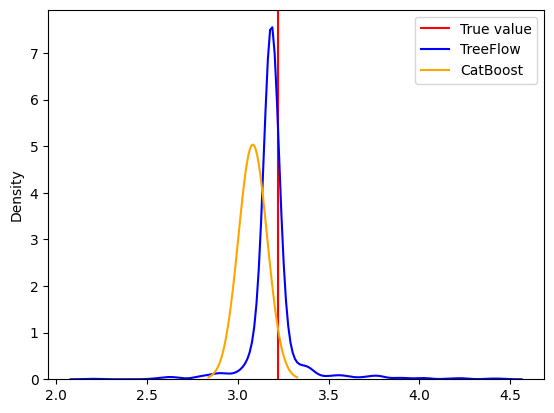

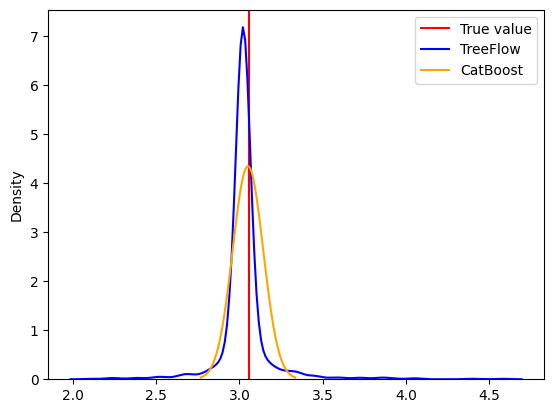

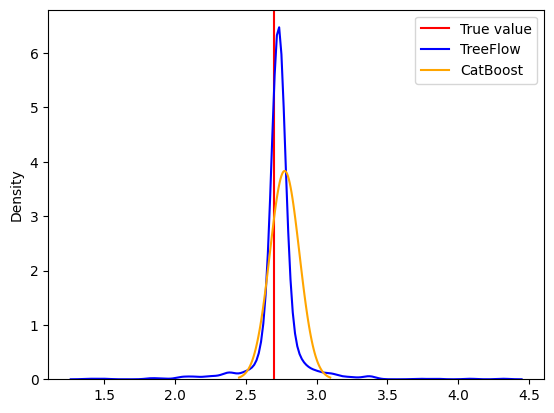

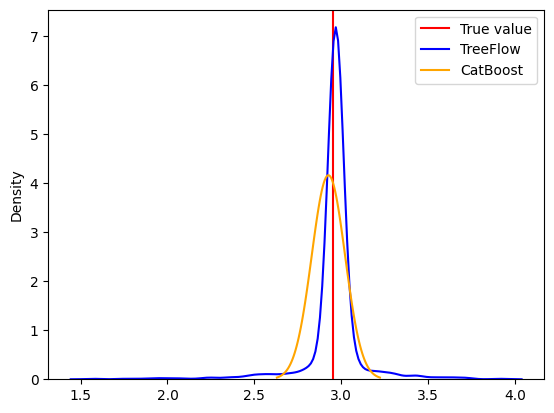

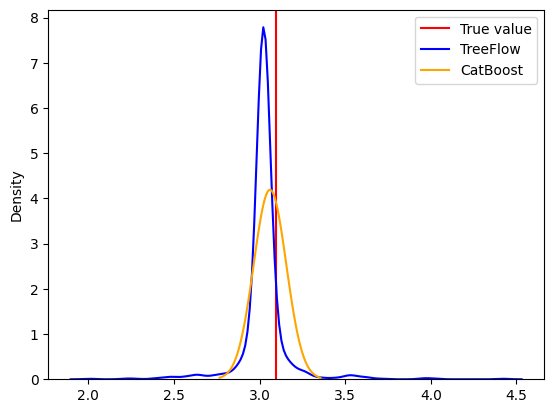

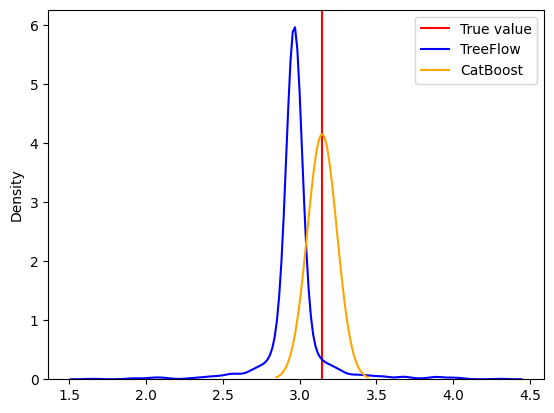

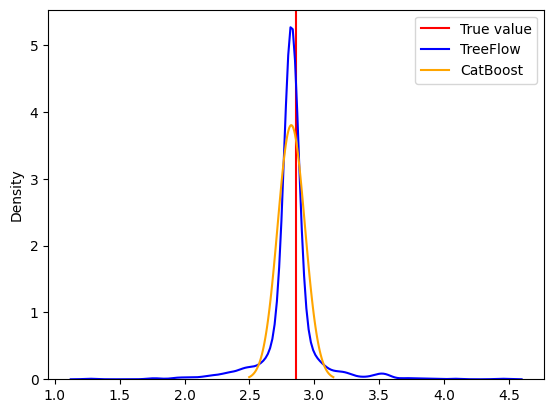

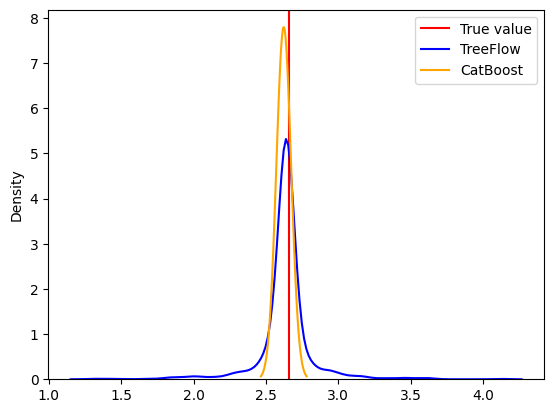

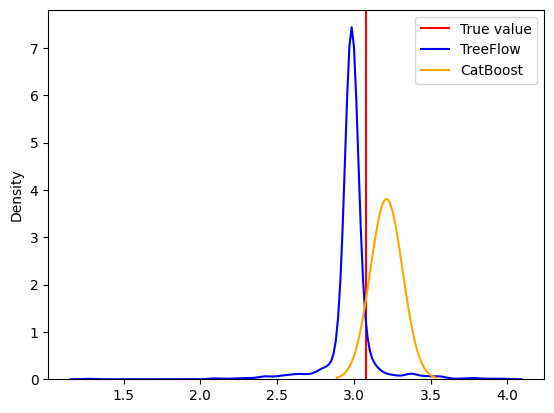

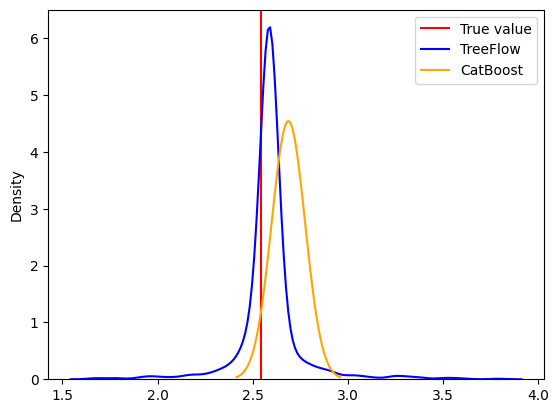

In [22]:
for i in range(10):
    plt.axvline(x=y_test.values[i, :], color='r', label='True value')

    sns.kdeplot(y_test_samples[i, :], color='blue', label='TreeFlow')

    x = np.linspace(
        stats.norm.ppf(0.001, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
        stats.norm.ppf(0.999, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
        100
    )
    plt.plot(x, stats.norm.pdf(x, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), color = 'orange', label='CatBoost')

    plt.legend()
    plt.show()